In [2]:
from polygon import RESTClient
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt

# Replace with your Polygon API key
# API_KEY = 'InxdvvQ5aFMwk5xWUpJUCpe8YHcimh8d'
API_KEY = 'hh0mSNz8kJH3asJCwAscTrtLt4RYb5RM'


def fetch_data(symbol, multiplier, timespan, from_date, to_date):
    client = RESTClient(API_KEY)
    aggs = client.get_aggs(symbol, multiplier, timespan, from_date, to_date)
    
    timestamps = []
    open_prices = []
    high_prices = []
    low_prices = []
    close_prices = []
    volumes = []
    
    for agg in aggs:
        timestamps.append(datetime.fromtimestamp(agg.timestamp // 1000))
        open_prices.append(agg.open)
        high_prices.append(agg.high)
        low_prices.append(agg.low)
        close_prices.append(agg.close)
        volumes.append(agg.volume)
        
    data = {
        't': timestamps,
        'o': open_prices,
        'h': high_prices,
        'l': low_prices,
        'c': close_prices,
        'v': volumes
    }
    
    df = pd.DataFrame(data)
    return df

def calculate_fibonacci_levels(first_hour_df):
    high = first_hour_df['h'].max()
    low = first_hour_df['l'].min()
    
    diff = high - low
    levels = {
        '0%': low,
        '23.6%': low + 0.236 * diff,
        '38.2%': low + 0.382 * diff,
        '50%': low + 0.5 * diff,
        '61.8%': low + 0.618 * diff,
        '100%': high
    }
    return levels

def identify_choch(df, window_size=2):
    choch = []
    for i in range(window_size, len(df)):
        avg_prev_close = df['c'].iloc[i-window_size:i].mean()
        if df['c'].iloc[i] > avg_prev_close and df['c'].iloc[i-1] <= avg_prev_close:
            choch.append('CHOCH Up')
        elif df['c'].iloc[i] < avg_prev_close and df['c'].iloc[i-1] >= avg_prev_close:
            choch.append('CHOCH Down')
        else:
            choch.append(None)
    df['CHOCH'] = [None] * window_size + choch
    return df

def generate_signals(df, levels):
    signals = []
    touched_level = None

    for i in range(len(df)):
        signal = 'Hold'
        if i < 13:
            signals.append(signal)
            continue
        
        for level_name, level_price in levels.items():
            if abs(df['c'].iloc[i] - level_price) < 0.01:
                touched_level = level_name
                break
        
        if touched_level in ['50%', '61.8%'] and df['CHOCH'].iloc[i] == 'CHOCH Up':
            signal = 'Buy'
        elif df['c'].iloc[i] < levels['50%'] and df['CHOCH'].iloc[i] == 'CHOCH Down':
            signal = 'Sell'
        elif touched_level in ['50%', '61.8%'] and df['CHOCH'].iloc[i] == 'CHOCH Down':
            signal = 'Sell'
        elif df['c'].iloc[i] > levels['50%'] and df['CHOCH'].iloc[i] == 'CHOCH Up':
            signal = 'Buy'
        
        signals.append(signal)
        if signal in ['Buy', 'Sell']:
            touched_level = None
    
    df['Signal'] = signals
    return df

def plot_signals(df, levels):
    fig, ax = plt.subplots(figsize=(14, 7))
    fib_colors = ['g', 'b', 'r', 'c', 'm', 'y']
    
    ax.plot(df['t'], df['c'], color='black', label='Close')
    buy_signals = df[df['Signal'] == 'Buy']
    sell_signals = df[df['Signal'] == 'Sell']
    ax.scatter(buy_signals['t'], buy_signals['c'], marker='^', s=100, color='green', label='Buy Signal')
    ax.scatter(sell_signals['t'], sell_signals['c'], marker='v', s=100, color='red', label='Sell Signal')
    
    for i, (level, price) in enumerate(levels.items()):
        color = fib_colors[i % len(fib_colors)]
        ax.hlines(price, xmin=df['t'].iloc[0], xmax=df['t'].iloc[-1], colors=color, linestyles='--', label=f'Fibonacci {level}')
    
    ax.set_title('Fibonacci Retracement Trading Signals with CHOCH')
    ax.set_ylabel('Price')
    ax.legend()
    
    plt.show()
    
def generate_date_array(year):
    dates = []
    # Start from the first day of the given year
    current_date = datetime(year, 1, 1)
    # End on the last day of the given year
    end_date = datetime(year + 1, 1, 1)
    
    while current_date < end_date:
        # Format the date as "yyyy-mm-dd" and add it to the list
        date_string = current_date.strftime("%Y-%m-%d")
        dates.append(date_string)
        # Move to the next day
        current_date += timedelta(days=1)
    
    return dates
def graph_profits(data, type_of_profit):
    # Extract keys and values
    dates = list(data.keys())
    values = list(data.values())

    # Convert string dates to datetime objects
    dates = [datetime.strptime(date, '%Y-%m-%d') for date in dates]

    # Create a plot
    plt.figure(figsize=(8, 4))
    plt.plot(dates, values, marker='o', linestyle='-', color='b')

    # Format the x-axis to show dates properly
    plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.DayLocator())

    # Label the axes
    plt.xlabel('Date')
    plt.ylabel(type_of_profit)
    plt.title(f'Model {type_of_profit} vs Holding Stock')

    # Rotate date labels for better readability
    plt.xticks(rotation=45)

    # Show grid
    plt.grid(True)

    # Display the plot
    plt.tight_layout()
    plt.show()


In [3]:
def fib_choch_strategy(ticker, day, cash=100000, shares=1000, percent_invest=20):
    df_5min = fetch_data(ticker, 5, 'minute', day, day)
    first_hour_df = df_5min.iloc[:12]
    levels = calculate_fibonacci_levels(first_hour_df)
    df_5min = identify_choch(df_5min)
    df_5min = generate_signals(df_5min, levels)
    
    df_1min = fetch_data(ticker, 1, 'minute', day, day)
    
    if len(df_1min)== 0:
        print(f"no data for this day {day} and stock")
        return(cash, shares, 0, 0, 0)

    transaction_times = df_5min[df_5min['Signal'].isin(['Buy', 'Sell'])][['t', 'Signal', 'c']].values.tolist()
    
    portfolio_val_s = cash + df_1min['c'].iloc[0] * shares
    amt = portfolio_val_s * percent_invest / 100

    # print("Running Simulation for Fibbonacci with", ticker, "on", day)
    # print("Number of Transactions: ", len(transaction_times))
    # print("Open Price, Close Price: ", df_1min['c'].iloc[0], df_1min['c'].iloc[-1])

    # print("Initial Cash and Shares: ", cash, shares)
    # print("BOD Portfolio Value: ", portfolio_val_s)

    shares_s = shares

    for order in transaction_times:
        signal_time, signal, price = order
        next_time = signal_time + timedelta(minutes=1)
        
        if next_time not in df_1min['t'].values:
            continue
        
        next_price = df_1min.loc[df_1min['t'] == next_time, 'c'].values[0]

        if signal == 'Buy':
            cash -= amt
            shares += amt / next_price
        elif signal == 'Sell':
            cash += amt
            shares -= amt / next_price
        #print(signal, cash, shares)

    portfolio_val_e = cash + df_1min['c'].iloc[-1] * shares
    profit = portfolio_val_e - portfolio_val_s

    profit_percentage = (profit / portfolio_val_s) * 100
    base_profit_percentage = shares_s*(df_1min['c'].iloc[-1]-df_1min['c'].iloc[0])/portfolio_val_s * 100
    
    
    # print("End Cash and Shares: ", cash, shares)
    # print("EOD Portfolio Value: ", portfolio_val_e)
    # print("Profit: ", profit, profit_percentage, "%")
    # print("Market Change w/o trades", base_profit_percentage)

    # print("Model outperforms market by", profit_percentage - base_profit_percentage)
    
    # plot_signals(df_5min, levels)
    
    return [cash, shares, profit, profit_percentage, base_profit_percentage]

In [4]:
def test_model(ticker, start_date, end_date, init_cash, init_shares, percent_invest):
    year1 = int(start_date[:4])
    year2 = int(end_date[:4])
    date_array = []
    for year in range(year1, year2+1):
        date_array += generate_date_array(year)

    alphas = []
    alphas_dict = {}
    profits_dict = {}
    start_d_idx = date_array.index(start_date)
    end_d_idx = date_array.index(end_date)
    cash = init_cash
    shares = init_shares

    for date in date_array[start_d_idx: end_d_idx+1]: #has to be 4 because 
        # print(date)
        cash, shares, profit, profit_percentage, base_profit_percentage = fib_choch_strategy(ticker, date, init_cash, init_shares, percent_invest)
        alphas.append(alpha:=(profit_percentage-base_profit_percentage))
        profits_dict[date] = profit_percentage
        alphas_dict[date] = alpha
        # print()

    # print(alphas_dict)

    return alphas_dict, profits_dict

#test but only 3 days allowed in free API
alphas_dict, profits_dict = test_model("AMZN", "2023-01-11", "2023-02-12", 100000, 1000, 20) 

MaxRetryError: HTTPSConnectionPool(host='api.polygon.io', port=443): Max retries exceeded with url: /v2/aggs/ticker/AMZN/range/1/minute/2023-01-13/2023-01-13 (Caused by ResponseError('too many 429 error responses'))

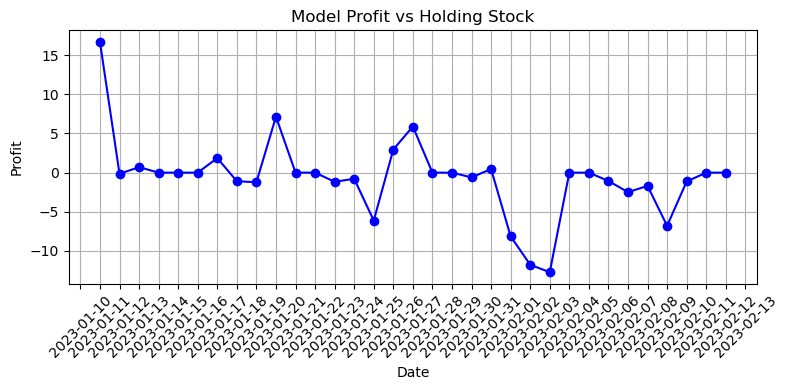

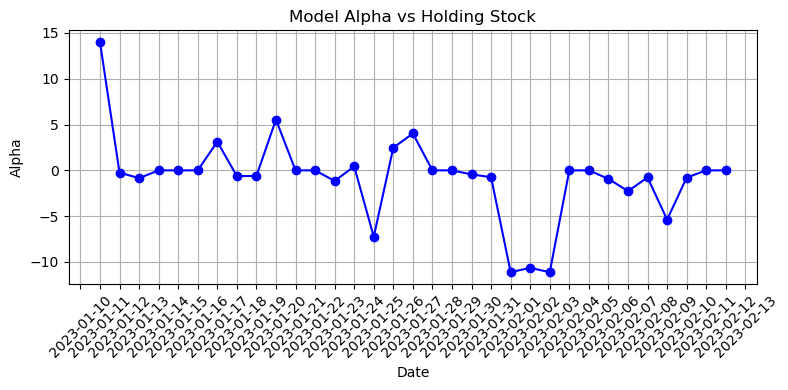

Average Profit: -0.6436965436831317
Average Alpha: -0.7672807672206449


In [ ]:
graph_profits(profits_dict, "Profit")
graph_profits(alphas_dict, "Alpha")
print(f"Average Profit: {sum(profits_dict.values())/len(profits_dict.values())}")
print(f"Average Alpha: {sum(alphas_dict.values())/len(alphas_dict.values())}")